<a href="https://colab.research.google.com/github/Raman-Raje/git-github/blob/master/2_DonorsChoose_EDA_TSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_4:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


## 1.1 Reading Data

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
project_data = pd.read_csv('/content/drive/My Drive/Assignments_DonorsChoose_2018/train_data.csv')
resource_data = pd.read_csv('/content/drive/My Drive/Assignments_DonorsChoose_2018/resources.csv')

In [4]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [5]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 1.2 Data Analysis

Number of projects thar are approved for funding  92706 , ( 84.85830404217927 %)
Number of projects thar are not approved for funding  16542 , ( 15.141695957820739 %)


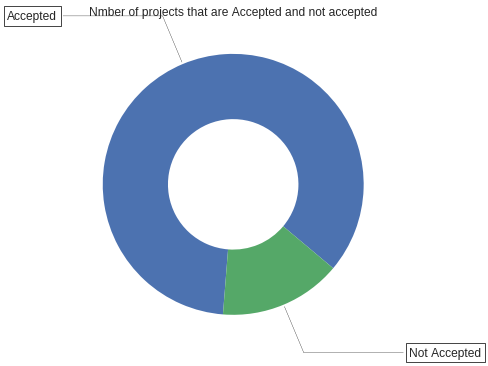

In [6]:
# PROVIDE CITATIONS TO YOUR CODE IF YOU TAKE IT FROM ANOTHER WEBSITE.
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


y_value_counts = project_data['project_is_approved'].value_counts()
print("Number of projects thar are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted")

plt.show()

### 1.2.1 Univariate Analysis: School State

In [0]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['state_code', 'num_proposals']

In [8]:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))
print('='*50)
print("States with highest % approvals")
print(temp.tail(5))

States with lowest % approvals
   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245
States with highest % approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


In [0]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [0]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

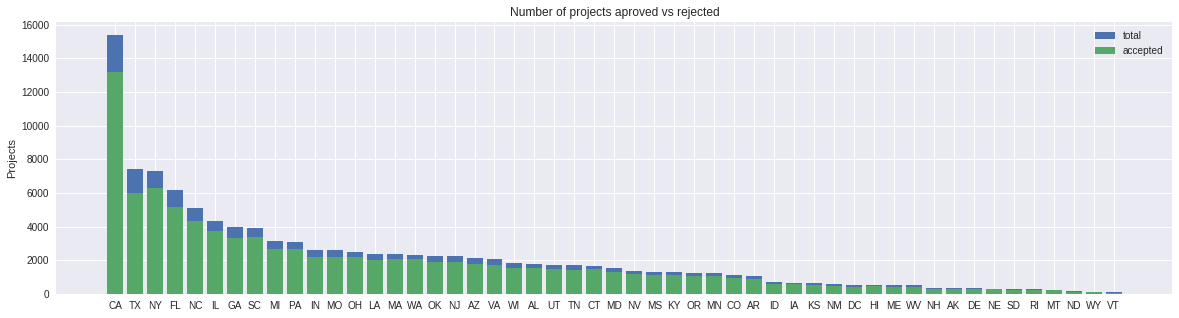

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [11]:
univariate_barplots(project_data, 'school_state', 'project_is_approved', False)

__SUMMARY: Every state has greater than 80% success rate in approval__

### 1.2.2 Univariate Analysis: teacher_prefix

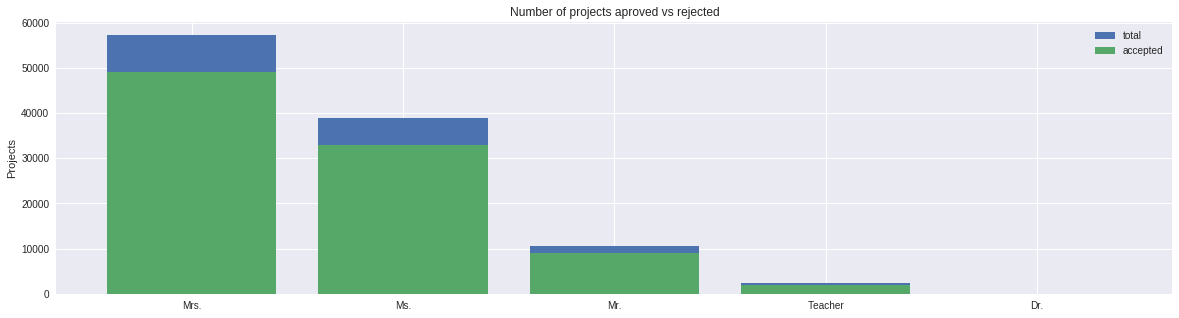

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [12]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)

### 1.2.3 Univariate Analysis: project_grade_category

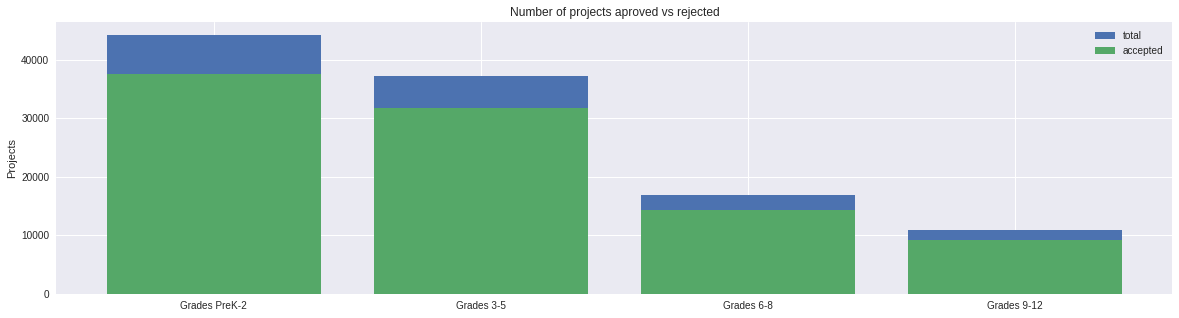

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [13]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', top=False)

### 1.2.4 Univariate Analysis: project_subject_categories

In [0]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [15]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports

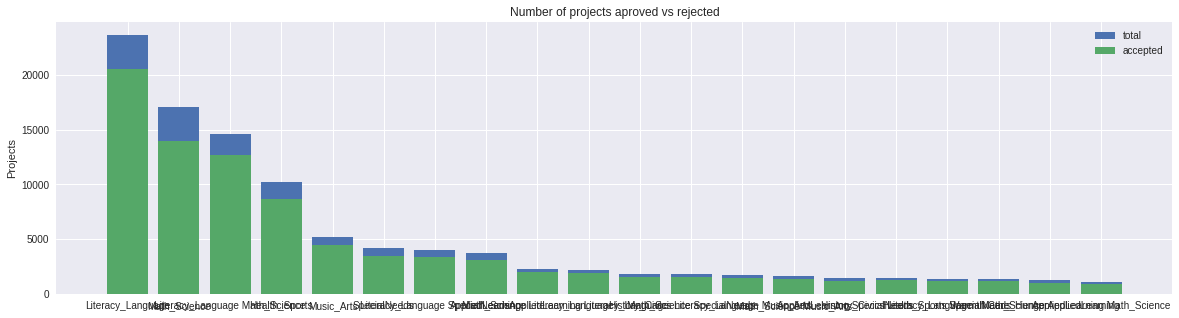

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [16]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)

In [0]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

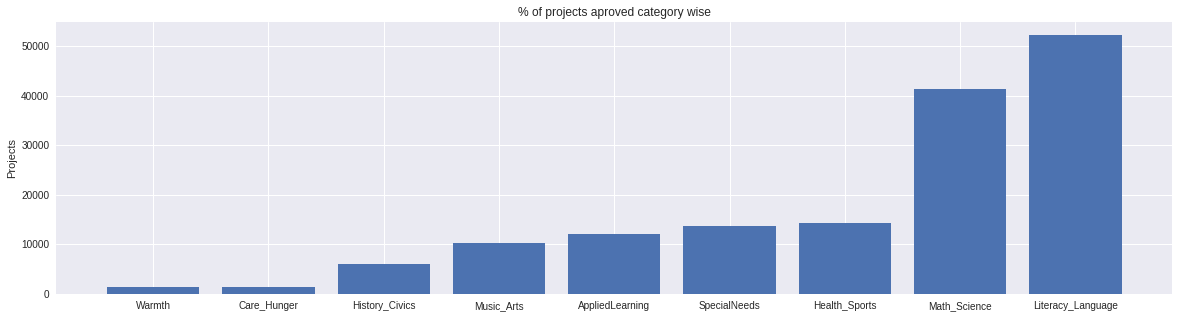

In [18]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [19]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


### 1.2.5 Univariate Analysis: project_subject_subcategories

In [0]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [21]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

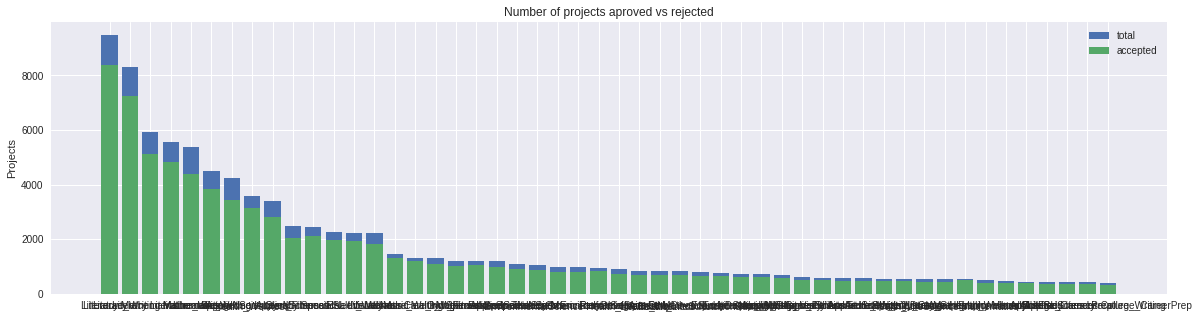

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [22]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)

In [0]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

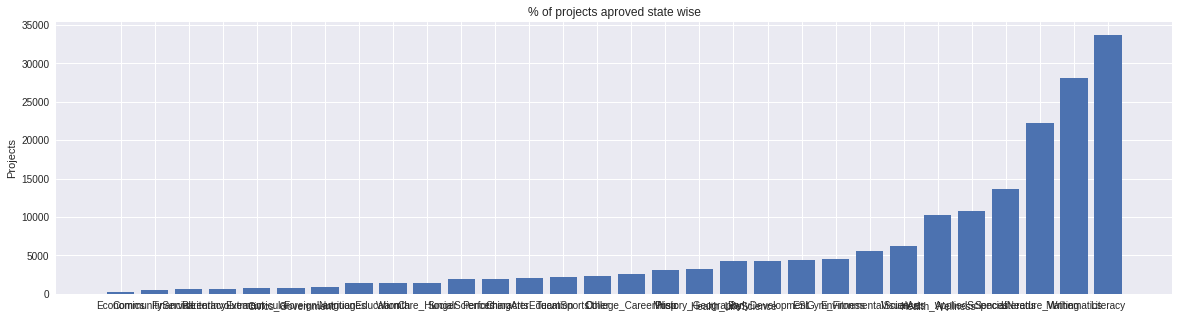

In [24]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [25]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


### 1.2.6 Univariate Analysis: Text features (Title)

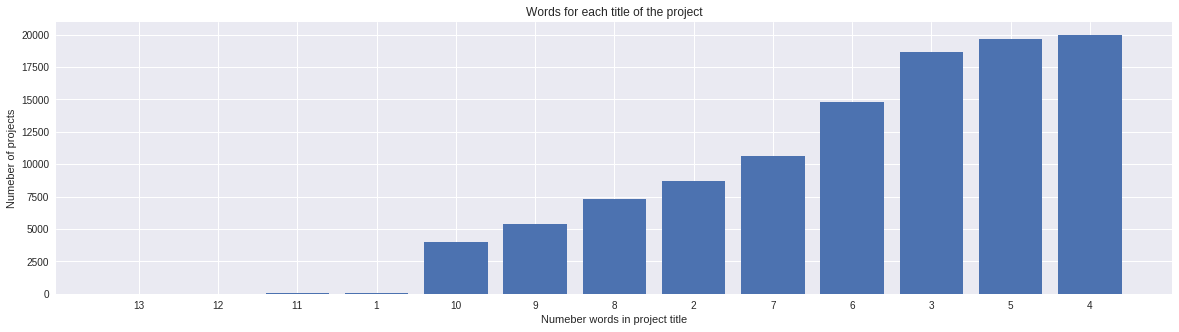

In [26]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.xlabel('Numeber words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [0]:
approved_title_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

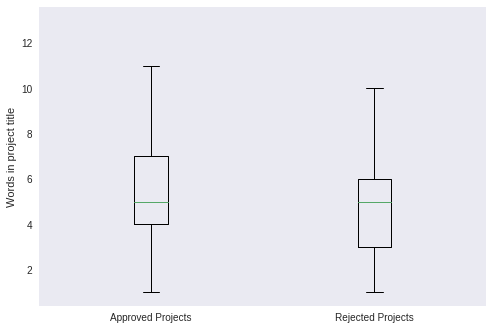

In [28]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

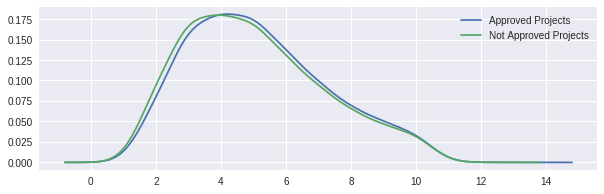

In [29]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

### 1.2.7 Univariate Analysis: Text features (Project Essay's)

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [0]:
approved_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

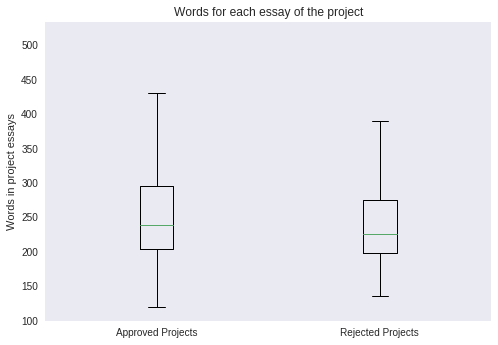

In [32]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')
plt.grid()
plt.show()

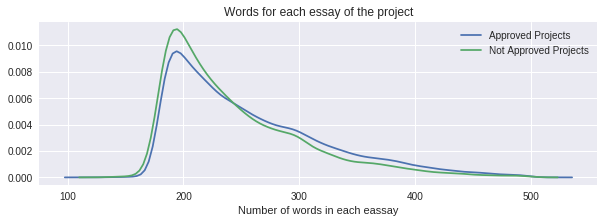

In [33]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

### 1.2.8 Univariate Analysis: Cost per project

In [34]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [35]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [0]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [0]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

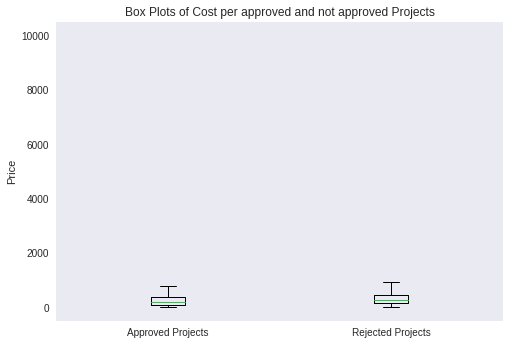

In [38]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()

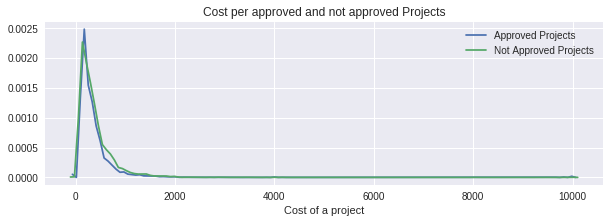

In [39]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

In [40]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

### 1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects

In [41]:
project_data["teacher_number_of_previously_posted_projects"].describe()

count    109248.000000
mean         11.153165
std          27.777154
min           0.000000
25%           0.000000
50%           2.000000
75%           9.000000
max         451.000000
Name: teacher_number_of_previously_posted_projects, dtype: float64

In [0]:
approved_number_ppp = project_data[project_data['project_is_approved']==1]['teacher_number_of_previously_posted_projects'].values

rejected_number_ppp = project_data[project_data['project_is_approved']==0]['teacher_number_of_previously_posted_projects'].values

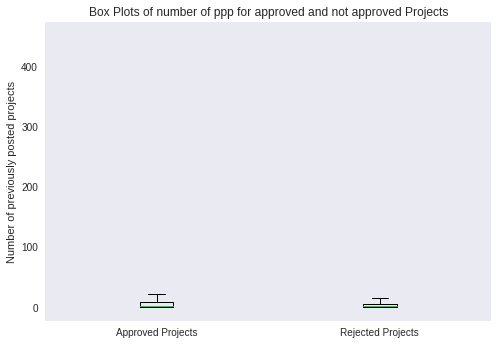

In [43]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_number_ppp, rejected_number_ppp])
plt.title('Box Plots of number of ppp for approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Number of previously posted projects')
plt.grid()
plt.show()

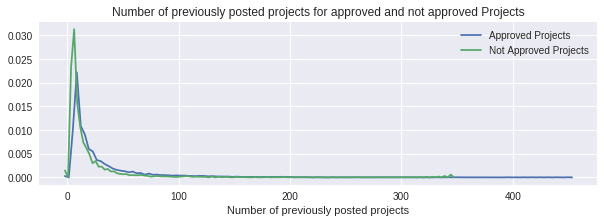

In [44]:
plt.figure(figsize=(10,3))
sns.distplot(approved_number_ppp, hist=False, label="Approved Projects")
sns.distplot(rejected_number_ppp, hist=False, label="Not Approved Projects")
plt.title('Number of previously posted projects for approved and not approved Projects')
plt.xlabel('Number of previously posted projects')
plt.legend()
plt.show()

In [45]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_number_ppp,i), 3), np.round(np.percentile(rejected_number_ppp,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.0        |          0.0          |
|     5      |        0.0        |          0.0          |
|     10     |        0.0        |          0.0          |
|     15     |        0.0        |          0.0          |
|     20     |        0.0        |          0.0          |
|     25     |        0.0        |          0.0          |
|     30     |        1.0        |          0.0          |
|     35     |        1.0        |          1.0          |
|     40     |        1.0        |          1.0          |
|     45     |        2.0        |          1.0          |
|     50     |        2.0        |          2.0          |
|     55     |        3.0        |          2.0          |
|     60     |        4.0        |          3.0          |
|     65     |        5.0        |          3.0         

###1.2.10 Univariate Analysis: project_resource_summary

In [0]:
# merge two column text dataframe: 
project_data["project_resource_summary"] = project_data["project_resource_summary"].map(str)

In [0]:
approved_resource_count = project_data[project_data['project_is_approved']==1]['project_resource_summary'].str.split().apply(len)
approved_resource_count = approved_resource_count.values

rejected_resource_count = project_data[project_data['project_is_approved']==0]['project_resource_summary'].str.split().apply(len)
rejected_resource_count = rejected_resource_count.values

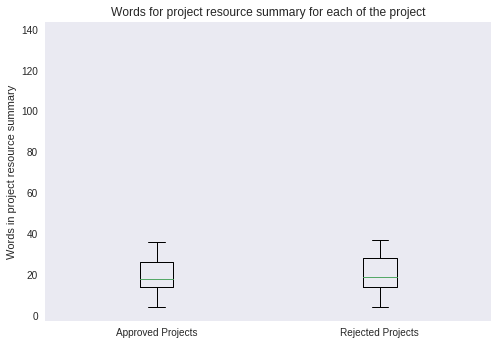

In [48]:
plt.boxplot([approved_resource_count, rejected_resource_count])
plt.title('Words for project resource summary for each of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project resource summary')
plt.grid()
plt.show()

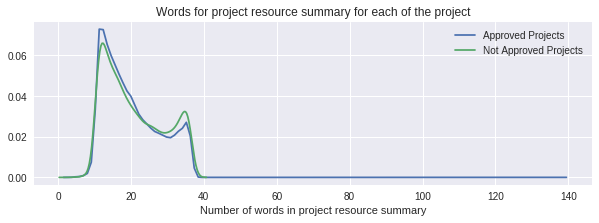

In [49]:
plt.figure(figsize=(10,3))
sns.distplot(approved_resource_count, hist=False, label="Approved Projects")
sns.distplot(rejected_resource_count, hist=False, label="Not Approved Projects")
plt.title('Words for project resource summary for each of the project')
plt.xlabel('Number of words in project resource summary')
plt.legend()
plt.show()

## 1.3 Text preprocessing

### 1.3.1 Essay Text

In [50]:
project_data.head(2)


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  price  quantity  
0  My students are English learners that are work...  154.6        23  
1  Our students arrive to our school eager to lea...  299.0         1

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [53]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:05<00:00, 1669.35it/s]


In [54]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

###1.3.2 Project title Text

In [55]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:03<00:00, 34646.50it/s]


###1.3.3 Project resource summary

In [56]:
project_data['project_resource_summary'] = project_data['project_resource_summary'].map(str)
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_resource = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_resource_summary'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_resource.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:07<00:00, 15449.92it/s]


##1.4 Categorical Data Preprocessing

###1.4.1 Teacher Prefix

In [57]:
project_data["teacher_prefix"].fillna("Teacher",inplace= True)
prefix = list(project_data['teacher_prefix'].values)
prefix_list = []
for i in prefix:
    temp = ""
    if "." in i: 
            i=i.replace('.','') 
    temp+=i.strip()+" " 
    prefix_list.append(temp.strip())
    
project_data['clean_prefix'] = prefix_list

my_counter = Counter()
for word in project_data['clean_prefix'].values:
  my_counter.update(word.split())

prefix_dict = dict(my_counter)
sorted_prefix_dict = dict(sorted(prefix_dict.items(), key=lambda kv: kv[1]))
print(sorted_prefix_dict)

{'Dr': 13, 'Teacher': 2363, 'Mr': 10648, 'Ms': 38955, 'Mrs': 57269}


In [58]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'clean_prefix'],
      dtype='object')

###1.4.2 Project Category

In [0]:
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


###1.4.3 Project Subcategory

In [0]:
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

###1.4.4 Project Grade Category

In [61]:
# preprocessing of grade category for train data

grade = list(project_data['project_grade_category'].values)
grade_list = []
for i in grade:
    temp = ""
    if "Grades" in i:
      i = i.replace("Grades","")
    if "6-8" in i:
      i = i.replace("6-8","six_eight")
    if "3-5" in i:
      i = i.replace("3-5","three_five")
    if "9-12" in i:
      i = i.replace("9-12","nine_twelve")
    if "PreK-2" in i:
      i = i.replace("PreK-2","prek_two")
    temp+=i.strip()+" " 
    grade_list.append(temp.strip())
    
project_data['clean_grade'] = grade_list

my_counter = Counter()
for word in project_data['clean_grade'].values:
  my_counter.update(word.split())

grade_dict = dict(my_counter)
sorted_grade_dict = dict(sorted(grade_dict.items(), key=lambda kv: kv[1]))
print(sorted_grade_dict)


{'nine_twelve': 10963, 'six_eight': 16923, 'three_five': 37137, 'prek_two': 44225}


###1.4.5 School State

In [0]:
#no need of preprocessing on school state

state = project_data["school_state"].value_counts()
sorted_state = dict(state)
sorted_state_dict = dict(sorted(sorted_state.items(), key=lambda kv: kv[1]))
project_data["clean_state"] = project_data["school_state"]


## 1. 4 Preparing data for models

In [63]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'clean_prefix', 'clean_grade', 'clean_state'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data
       
       - quantity : numerical
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### 1.4.1 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

In [64]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_categories'].values)
print(vectorizer.get_feature_names())


categories_one_hot = vectorizer.transform(project_data['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (109248, 9)


In [65]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())


sub_categories_one_hot = vectorizer.transform(project_data['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (109248, 30)


In [66]:
vectorizer = CountVectorizer(vocabulary=list(prefix_dict.keys()), lowercase=False, binary=True)

# fitting on train data
vectorizer.fit(project_data['clean_prefix'].values)
print(vectorizer.get_feature_names())

# for train data
prefix_one_hot = vectorizer.transform(project_data['clean_prefix'].values)
print("Shape of matrix after one hot encodig ",prefix_one_hot.shape)


['Mrs', 'Mr', 'Ms', 'Teacher', 'Dr']
Shape of matrix after one hot encodig  (109248, 5)


In [67]:
vectorizer = CountVectorizer(vocabulary=list(grade_dict.keys()), lowercase=False, binary=True)

# fitting on train data
vectorizer.fit(project_data['clean_grade'].values)
print(vectorizer.get_feature_names())

# for train data
grade_one_hot = vectorizer.transform(project_data['clean_grade'].values)
print("Shape of matrix after one hot encodig ",grade_one_hot.shape)


vectorizer = CountVectorizer(vocabulary=list(sorted_state_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_state'].values)
print(vectorizer.get_feature_names())
state_one_hot = vectorizer.transform(project_data['clean_state'].values)

['prek_two', 'six_eight', 'three_five', 'nine_twelve']
Shape of matrix after one hot encodig  (109248, 4)
['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']


### 1.4.2 Vectorizing Text data

#### 1.4.2.1 Bag of words

In [68]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (109248, 16623)


In [69]:
vectorizer.fit(preprocessed_title)
title_bow = vectorizer.transform(preprocessed_title)
print("Shape of matrix : ",title_bow.shape)

Shape of matrix :  (109248, 3329)


#### 1.4.2.3 TFIDF vectorizer

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 16623)


In [71]:
title_tfidf = vectorizer.fit_transform(preprocessed_title)
print("Shape of matrix after one hot encodig ",title_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 3329)


#### 1.4.2.5 Using Pretrained Models: Avg W2V

In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('/content/drive/My Drive/Assignments_DonorsChoose_2018/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [73]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|██████████| 109248/109248 [00:35<00:00, 3068.90it/s]

109248
300


In [74]:
title_avg_w2v_vectors = []
for sentence in tqdm(preprocessed_title): 
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split(): 
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    title_avg_w2v_vectors.append(vector)

print(len(title_avg_w2v_vectors))
print(len(title_avg_w2v_vectors[0]))

100%|██████████| 109248/109248 [00:01<00:00, 60800.89it/s]

109248
300


In [75]:
resource_avg_w2v_vectors = []
for sentence in tqdm(preprocessed_resource): 
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split(): 
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    resource_avg_w2v_vectors.append(vector)

print(len(resource_avg_w2v_vectors))
print(len(resource_avg_w2v_vectors[0]))

100%|██████████| 109248/109248 [00:03<00:00, 28950.80it/s]

109248
300


#### 1.4.2.7 Using Pretrained Models: TFIDF weighted W2V

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [77]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|██████████| 109248/109248 [03:47<00:00, 479.64it/s]

109248
300


In [78]:
# for title 
tfidf_model.fit(preprocessed_title)

dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    title_tfidf_w2v_vectors.append(vector)

print(len(title_tfidf_w2v_vectors))

100%|██████████| 109248/109248 [00:04<00:00, 22426.01it/s]

109248


### 1.4.3 Vectorizing Numerical features

In [79]:
from sklearn.preprocessing import StandardScaler

price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))

Mean : 298.1193425966608, Standard deviation : 367.49634838483496


In [80]:
price_scalar = StandardScaler()
price_scalar.fit(project_data["quantity"].values.reshape(-1, 1))
print(f"Mean of Quantity : {price_scalar.mean_[0]}, Standard deviation of Quantity : {np.sqrt(price_scalar.var_[0])}")

#train data quantity standardization
quantity_standardized = price_scalar.transform(project_data["quantity"].values.reshape(-1, 1))


Mean of Quantity : 16.965610354422964, Standard deviation of Quantity : 26.182821919093175


In [81]:
price_scalar = StandardScaler()
price_scalar.fit(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) 
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

#train data ppp standardization
number_ppp_standardized = price_scalar.transform(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean : 11.153165275336848, Standard deviation : 27.77702641477403


### 1.4.4 Merging all the above features

- we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

In [82]:
print("*"*70)
print("Categorical Features that are considered :- ")
print("Subject Categories :- ",categories_one_hot.shape)
print("Subject Sub-Categories :- ",sub_categories_one_hot.shape)
print("Sudent Grade :- ",grade_one_hot.shape)
print("School State :- ",state_one_hot.shape)
print("Teacher Prefix :- ",prefix_one_hot.shape)
print("*"*70)

**********************************************************************
Categorical Features that are considered :- 
Subject Categories :-  (109248, 9)
Subject Sub-Categories :-  (109248, 30)
Sudent Grade :-  (109248, 4)
School State :-  (109248, 51)
Teacher Prefix :-  (109248, 5)
**********************************************************************


In [83]:
print("Text Features that are considered :- ")
print("*"*70)
print("Project Essay BOW:- ",text_bow.shape)
print("Project Essay TFIDF:- ",text_tfidf.shape)
print("*"*70)
print("Project Title BOW:- ",title_bow.shape)
print("Project Title TFIDF:- ",title_tfidf.shape)
print("*"*70)

Text Features that are considered :- 
**********************************************************************
Project Essay BOW:-  (109248, 16623)
Project Essay TFIDF:-  (109248, 16623)
**********************************************************************
Project Title BOW:-  (109248, 3329)
Project Title TFIDF:-  (109248, 3329)
**********************************************************************


In [0]:
#combining all feature into one
from scipy.sparse import hstack

set1 = hstack((categories_one_hot,sub_categories_one_hot,prefix_one_hot,grade_one_hot,state_one_hot,title_bow,price_standardized,quantity_standardized,number_ppp_standardized))
set2 = hstack((categories_one_hot,sub_categories_one_hot,prefix_one_hot,state_one_hot,grade_one_hot,title_tfidf,price_standardized,quantity_standardized,number_ppp_standardized))
set3 = hstack((categories_one_hot,sub_categories_one_hot,prefix_one_hot,state_one_hot,grade_one_hot,title_avg_w2v_vectors,price_standardized,quantity_standardized,number_ppp_standardized))
set4 = hstack((categories_one_hot,sub_categories_one_hot,prefix_one_hot,state_one_hot,grade_one_hot,title_tfidf_w2v_vectors,price_standardized,quantity_standardized,number_ppp_standardized))

##Assignment 2: Apply TSNE

Considering only 4k data points

In [0]:
from sklearn.manifold import TSNE
y = project_data["project_is_approved"][0:4000]
tsne = TSNE(n_components=2, perplexity=10, learning_rate=200)

<h2> 2.1 TSNE with `BOW` encoding of `project_title` feature </h2>

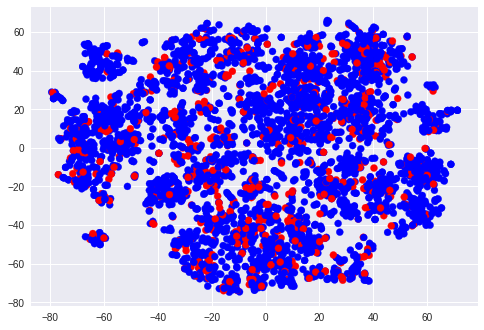

In [86]:
set1_embedding = tsne.fit_transform(set1.tocsr()[0:4000,:].toarray())


for_tsne = np.hstack((set1_embedding, y.reshape(-1,1)))
for_tsne_df_1 = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])

colors = {0:'red', 1:'blue', 2:'green'}

plt.scatter(for_tsne_df_1['Dimension_x'], for_tsne_df_1['Dimension_y'], c=for_tsne_df_1['Score'].apply(lambda x: colors[x]))
plt.show()

<h2> 2.2 TSNE with `TFIDF` encoding of `project_title` feature </h2>

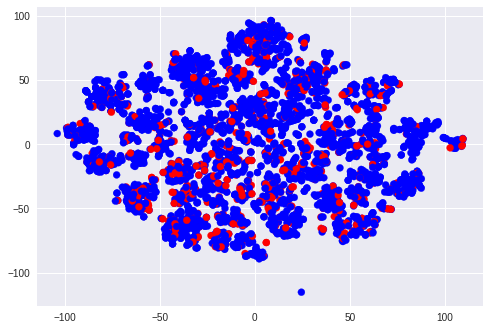

In [87]:
set2 = set2
set2_embedding = tsne.fit_transform(set2.tocsr()[0:4000,:].toarray())


for_tsne = np.hstack((set2_embedding, y.reshape(-1,1)))
for_tsne_df_2 = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])

colors = {0:'red', 1:'blue', 2:'green'}

plt.scatter(for_tsne_df_2['Dimension_x'], for_tsne_df_2['Dimension_y'], c=for_tsne_df_2['Score'].apply(lambda x: colors[x]))
plt.show()

<h2> 2.3 TSNE with `AVG W2V` encoding of `project_title` feature </h2>

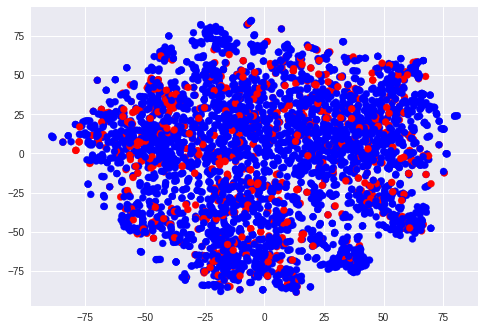

In [88]:
set3_embedding = tsne.fit_transform(set3.tocsr()[0:4000,:].toarray())


for_tsne = np.hstack((set3_embedding, y.reshape(-1,1)))
for_tsne_df_3 = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])

colors = {0:'red', 1:'blue', 2:'green'}

plt.scatter(for_tsne_df_3['Dimension_x'], for_tsne_df_3['Dimension_y'], c=for_tsne_df_3['Score'].apply(lambda x: colors[x]))
plt.show()

<h2> 2.4 TSNE with `TFIDF Weighted W2V` encoding of `project_title` feature </h2>

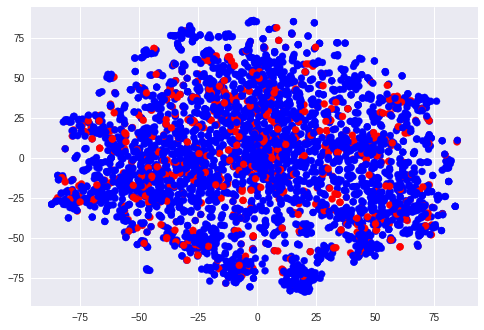

In [89]:
set4_embedding = tsne.fit_transform(set4.tocsr()[0:4000,:].toarray())


for_tsne = np.hstack((set4_embedding, y.reshape(-1,1)))
for_tsne_df_4 = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])

colors = {0:'red', 1:'blue', 2:'green'}

plt.scatter(for_tsne_df_4['Dimension_x'], for_tsne_df_4['Dimension_y'], c=for_tsne_df_4['Score'].apply(lambda x: colors[x]))
plt.show()

<h2>2.5 Concatenation of all</h2>

In [0]:
con_set =   hstack((categories_one_hot,sub_categories_one_hot,prefix_one_hot,state_one_hot,grade_one_hot,price_standardized,quantity_standardized,number_ppp_standardized,avg_w2v_vectors,title_avg_w2v_vectors,resource_avg_w2v_vectors))

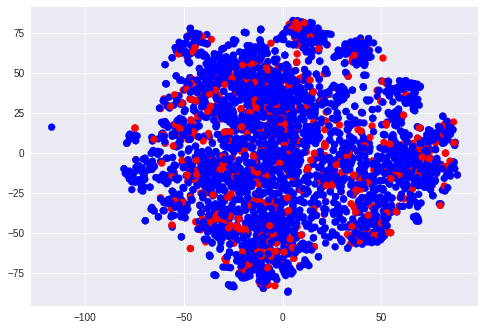

In [91]:
set_embedding = tsne.fit_transform(con_set.tocsr()[0:4000,:].toarray())


for_tsne = np.hstack((set_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])

colors = {0:'red', 1:'blue', 2:'green'}

plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

<h2> 2.5 Summary </h2>

In [0]:
# 1. Best results found for perplexity = 10
# 2. Data points are not seperable
# 3. 4k data point used for computation due to memory